In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from scipy.ndimage import distance_transform_edt

In [15]:
data = {
    "train": {
        "images": [],
        "ground_truth": [],
        "predicted_mask": []
    },
    "validation": {
        "images": [],
        "ground_truth": [],
        "predicted_mask": []
    },
    "test": {
        "images": [],
        "ground_truth": [],
        "predicted_mask": []
    }
}

# Open the image file
base_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_unet/")) # SCLabels_prediction_by_set_attention_unet

base_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_attention_unet/"))


# data_dirs = ["images", "mask", "predicted_mask"]
sub_dirs = ["train", "validation", "test"]

for sub_dir in sub_dirs:
    for file in os.listdir(os.path.join(base_path, "images", sub_dir)):
        if file.endswith(".jpg"):
            path = os.path.join(base_path, "images", sub_dir, file)
            data[sub_dir]["images"].append(path)

            file = file.replace("image.jpg", "mask.png")
            path = os.path.join(base_path, "masks", sub_dir, file)
            data[sub_dir]["ground_truth"].append(path)

            # file = file.replace("mask.png", "pred.png")
            path = os.path.join(base_path, "predicted_mask", sub_dir, file)
            data[sub_dir]["predicted_mask"].append(path)

print("Data loaded")

Data loaded


In [3]:
def transform_to_binary(mask, value):
    mask = np.where(mask == value, 1, 0).astype(np.uint8)
    return mask

def chamfer_distance(pred, ground_truth):
    dist_transform = distance_transform_edt(1 - ground_truth)
    distances = dist_transform[pred > 0]
    mean_distance = np.mean(distances)

    return mean_distance

def find_shoreline(pred, land_pixel, sea_pixel):
    shoreline = np.zeros_like(pred)
    for i in range(pred.shape[0]):
        for j in range(1, pred.shape[1]):
            if pred[i, j] == land_pixel and pred[i, j-1] == sea_pixel:
                shoreline[i, j] = 1
            if pred[i, j] == sea_pixel and pred[i, j-1] == land_pixel:
                shoreline[i, j-1] = 1

    for j in range(pred.shape[1]):
        for i in range(1, pred.shape[0]):
            if pred[i, j] == land_pixel and pred[i-1, j] == sea_pixel:
                shoreline[i, j] = 1
            if pred[i, j] == sea_pixel and pred[i-1, j] == land_pixel:
                shoreline[i-1, j] = 1
            
    return shoreline

def find_largest_contour(shoreline_mask):
    # Trobar els contorns a la màscara de la línia de costa
    contours, _ = cv2.findContours(shoreline_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Trobar el contorn més gran
    largest_contour = max(contours, key=len)

    return largest_contour

def transform_mask_to_shoreline2(pred_path, no_data=0, landward=75, seaward=150):
    pred = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

    shoreline = find_shoreline(pred, landward, seaward)

    largest_contour = find_largest_contour(shoreline)

    # Crear una màscara per dibuixar el contorn més gran
    largest_shoreline = np.zeros_like(shoreline)
    cv2.drawContours(largest_shoreline, [largest_contour], -1, 1, thickness=cv2.FILLED)

    return largest_shoreline

    # return shoreline

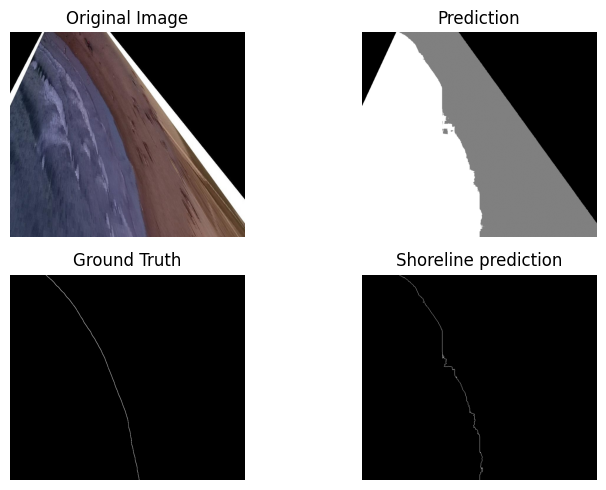

In [4]:
index = 85 # 85 # 160 # 102
img = data["test"]["images"][index]
ground_truth = data["test"]["ground_truth"][index]
pred_path = data["test"]["predicted_mask"][index]

img = cv2.imread(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ground_truth = cv2.imread(ground_truth, cv2.IMREAD_GRAYSCALE)
ground_truth = transform_to_binary(ground_truth, 3)

pred = transform_mask_to_shoreline2(pred_path = pred_path, landward=1, seaward=2)


fig, axes = plt.subplots(2, 2, figsize=(8, 5))

# Mostra cada imatge en un subplot
axes[0][0].imshow(img)
axes[0][0].set_title("Original Image")
axes[0][0].axis("off")

pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
axes[0][1].imshow(pred_mask, cmap="gray")
axes[0][1].set_title("Prediction")
axes[0][1].axis("off")

axes[1][0].imshow(ground_truth, cmap="gray")
axes[1][0].set_title("Ground Truth")
axes[1][0].axis("off")

axes[1][1].imshow(pred, cmap="gray")
axes[1][1].set_title("Shoreline prediction")
axes[1][1].axis("off")

plt.tight_layout()
plt.show()


In [9]:
def compute_chamfer_distance(data_set):

    coasts = ["agrelo", "cies", "cadiz", "samarador", "arenaldentem", "global"]
    global_distance = {
        "agrelo": [],
        "cies": [],
        "cadiz": [],
        "samarador": [],
        "arenaldentem": [],
        "global": []
    }

    min_distance = 1000
    min_img = ""
    min_index = 0

    for index in range(len(data_set["images"])):
        # print(data_set["images"][index])
        img_path = data_set["images"][index]
        ground_truth_path = data_set["ground_truth"][index]
        pred_path = data_set["predicted_mask"][index]

        img = cv2.imread(img_path)
        ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
        ground_truth = transform_to_binary(ground_truth, 3)

        pred = transform_mask_to_shoreline2(pred_path, landward=1, seaward=2)

        distance = chamfer_distance(pred, ground_truth)

        for coast in coasts:
            if coast in img_path:
                global_distance[coast].append(distance)
        
        global_distance["global"].append(distance)

        if distance < min_distance:
            min_distance = distance
            min_img = img_path
            min_index = index

        # distance = chamfer_distance(pred, ground_truth)
        # global_distance.append(distance)
        # print(index, distance, data_set["images"][index])
    
    # print("Mean distance: ", np.mean(global_distance))
    # print("Std distance: ", np.std(global_distance))
    # print("Max distance: ", np.max(global_distance))
    # print("Min distance: ", np.min(global_distance))

    for coast in coasts:
        print(f"\n{coast} - {len(global_distance[coast])} images")
        print("Mean distance: ", np.mean(global_distance[coast]))
        print("Std distance: ", np.std(global_distance[coast]))
        print("Max distance: ", np.max(global_distance[coast]))
        print("Min distance: ", np.min(global_distance[coast]))

    print(min_distance, min_img, min_index)

In [17]:
print("Train set")
compute_chamfer_distance(data["train"])

Train set

agrelo - 170 images
Mean distance:  2.9572147190570237
Std distance:  4.211373542213474
Max distance:  48.26920945139677
Min distance:  0.95473181204743

cies - 301 images
Mean distance:  1.2459079499748105
Std distance:  0.9129389281326924
Max distance:  6.473986446835663
Min distance:  0.07920792079207921

cadiz - 662 images
Mean distance:  4.596336127796097
Std distance:  5.312956022353017
Max distance:  128.6029249407082
Min distance:  1.0468180365837885

samarador - 39 images
Mean distance:  6.095043015200448
Std distance:  9.409034397151729
Max distance:  62.23552912918076
Min distance:  1.453110405348408

arenaldentem - 28 images
Mean distance:  3.1332768602933823
Std distance:  1.991901896747496
Max distance:  10.320322988628787
Min distance:  1.123671475465329

global - 1200 images
Mean distance:  3.5382981178868005
Std distance:  4.843903489539329
Max distance:  128.6029249407082
Min distance:  0.07920792079207921
0.07920792079207921 c:\Users\josep\Documents\SOCIB\

In [18]:
print("\nValidation set")
compute_chamfer_distance(data["validation"])


Validation set

agrelo - 49 images
Mean distance:  5.854071726524854
Std distance:  9.323351943114371
Max distance:  46.37465190869321
Min distance:  0.9749430663366819

cies - 85 images
Mean distance:  3.4082946720604306
Std distance:  14.157640902725205
Max distance:  130.25970580074156
Min distance:  0.26574235603170693

cadiz - 189 images
Mean distance:  8.93274448904764
Std distance:  8.726641967853789
Max distance:  58.241723978972225
Min distance:  1.7164778157997667

samarador - 12 images
Mean distance:  17.005488816587455
Std distance:  28.201664710201033
Max distance:  108.89659365920825
Min distance:  3.7474572806647797

arenaldentem - 8 images
Mean distance:  3.9561973769285244
Std distance:  3.4726629116035324
Max distance:  12.642974081452225
Min distance:  1.5954952560242746

global - 343 images
Mean distance:  7.290258644225469
Std distance:  11.884242393609187
Max distance:  130.25970580074156
Min distance:  0.26574235603170693
0.26574235603170693 c:\Users\josep\Docum

In [19]:
print("\nTest set")
compute_chamfer_distance(data["test"])


Test set

agrelo - 25 images
Mean distance:  6.893262368867518
Std distance:  9.380688132036834
Max distance:  46.958392417107156
Min distance:  0.9004075629926341

cies - 44 images
Mean distance:  1.5092822225216602
Std distance:  0.9710234588616733
Max distance:  4.940758746150937
Min distance:  0.148765516033367

cadiz - 95 images
Mean distance:  11.964957142650597
Std distance:  10.523255403909191
Max distance:  60.28773778619475
Min distance:  2.458106555790416

samarador - 6 images
Mean distance:  12.218600784355173
Std distance:  10.18731981393823
Max distance:  31.490142386013353
Min distance:  0.8891680690657148

arenaldentem - 4 images
Mean distance:  4.646698129932453
Std distance:  1.6238858832937109
Max distance:  7.442169529528431
Min distance:  3.4268532317214713

global - 174 images
Mean distance:  8.432812085001775
Std distance:  9.852888035558506
Max distance:  60.28773778619475
Min distance:  0.148765516033367
0.148765516033367 c:\Users\josep\Documents\SOCIB\Shoreli